## Business Understanding

The FCC/SamKnows "Measuring Broadband America" dataset is a collaborative initiative between the Federal Communications Commission (FCC) and SamKnows, designed to provide comprehensive, real-world data on the performance of broadband internet services across the United States. The dataset includes detailed measurements of broadband speed, latency, and reliability, collected from volunteer households using specialized measurement tools and software. 

The task is to provide analysis of Internet traffic performance taking into account download and upload packages.

## Data understanding

We are dealing with two similarly structured datasets from year 2021 and 2023. From the perspective of my study these files contain core measurements:

Download & upload performance:

- `curr_lct_dl.csv` – Contain download performance (e.g., throughput/speed, latency, packet loss),

- `curr_lct_ul.csv` – Contain upload performance,

- `curr_dlping.csv` – Contain download-related latency (ping) information,

- `curr_ulping.csv` – Contain upload-related ping statistics.

Supporting network performance metrics (for correlation analysis):

- `curr_ping.csv` – General ping measurements (latency),

- `curr_udplatency.csv, curr_udplatency6.csv` – UDP latency, both IPv4 and IPv6,

- `curr_udpjitter.csv` – Jitter (variability in latency),

- `curr_udpcloss.csv` – Packet loss,

- `curr_httpget.csv, curr_httpgetmt.csv` – HTTP GET measurements (potentially related to throughput).

From files above, several columns were selected to futher analysis:

Download (`curr_lct_dl.csv`) & upload performance (`curr_lst_ul.csv`):

- `dtime` - Timestamp of the test. Important for temporal analysis (time-based trends),
  
- `target` - Contains data about location

- `packets_received` - Number of packets successfully received,

- `packets_sent` - Number of packets sent (helps analyze how many packets were transmitted in comparison to what was received),

- `bytes_total` - Total bytes transferred. This is key to assessing the overall data volume and performance,

- `bytes_sec` - This likely represents download/upload speed (bytes per second),

- `error_code` - This can help identify failed transfers, so it's useful for success/failure analysis,

- `successes` - The count of successful packets or transfers. You may use this to evaluate successful performance,

- `failures` - This helps analyze the failure rate.


Latency data for download (`curr_dlping.csv`) / upload (`curr_ulping.csv`) connections:

- `rtt_avg` - Average Round-Trip Time (RTT),

- `rtt_min` - Minimum RTT,

- `rtt_max` - Maximum RTT,

- `rtt_std` - Standard deviation of RTT (indicates jitter).

- `successes` and `failures` - To understand if packets were successfully pinged.


In [1]:
import polars as pl
import os 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#Read the CSV files

current_path = os.getcwd()
dl_21_path = os.path.join(current_path, "202102", "curr_lct_dl.csv")
dl_23_path = os.path.join(current_path, "202302", "curr_lct_dl.csv")
ul_21_path = os.path.join(current_path, "202102", "curr_lct_ul.csv")
ul_23_path = os.path.join(current_path, "202302", "curr_lct_ul.csv")
ping_dl_21_path = os.path.join(current_path, "202102", "curr_dlping.csv")
ping_dl_23_path = os.path.join(current_path, "202302", "curr_dlping.csv")
ping_ul_21_path = os.path.join(current_path, "202102", "curr_ulping.csv")
ping_ul_23_path = os.path.join(current_path, "202302", "curr_ulping.csv")

cols_performance = [
    "dtime",
    "target",             
    "packets_received",
    "packets_sent",
    "bytes_total",
    "bytes_sec",
    "error_code",
    "successes",
    "failures"
]

cols_latency = [ 
    "rtt_avg",
    "rtt_min",
    "rtt_max",
    "rtt_std",
    "successes",
    "failures"
]

dl_21 = pl.scan_csv(dl_21_path).select(cols_performance).collect()
dl_23 = pl.scan_csv(dl_23_path).select(cols_performance).collect()
ul_21 = pl.scan_csv(ul_21_path).select(cols_performance).collect()
ul_23 = pl.scan_csv(ul_23_path).select(cols_performance).collect()
ping_dl_21 = pl.scan_csv(ping_dl_21_path).select(cols_latency).collect()
ping_dl_23 = pl.scan_csv(ping_dl_23_path).select(cols_latency).collect()
ping_ul_21 = pl.scan_csv(ping_ul_21_path).select(cols_latency).collect()
ping_ul_23 = pl.scan_csv(ping_ul_23_path).select(cols_latency).collect()

## Data preparation


In [3]:
# Print basic statistics for performance data (download/upload, 2021/2023)
def print_performance_stats(df, label):
    print(f"--- {label} ---")
    print(df.select([
        pl.col("bytes_total").mean().alias("Mean bytes_total"),
        pl.col("bytes_total").std().alias("Std bytes_total"),
        pl.col("bytes_sec").mean().alias("Mean bytes_sec"),
        pl.col("bytes_sec").std().alias("Std bytes_sec"),
        pl.col("packets_received").mean().alias("Mean packets_received"),
        pl.col("packets_sent").mean().alias("Mean packets_sent"),
        pl.col("successes").sum().alias("Total successes"),
        pl.col("failures").sum().alias("Total failures"),
    ]))
    print()

print_performance_stats(dl_21, "Download 2021")
print_performance_stats(ul_21, "Upload 2021")
print_performance_stats(dl_23, "Download 2023")
print_performance_stats(ul_23, "Upload 2023")

--- Download 2021 ---
shape: (1, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Mean bytes ┆ Std bytes_ ┆ Mean       ┆ Std       ┆ Mean pack ┆ Mean pack ┆ Total     ┆ Total     │
│ _total     ┆ total      ┆ bytes_sec  ┆ bytes_sec ┆ ets_recei ┆ ets_sent  ┆ successes ┆ failures  │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ved       ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64       ┆ ---       ┆ f64       ┆ i64       ┆ i64       │
│            ┆            ┆            ┆           ┆ f64       ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 105475.810 ┆ 44739.5569 ┆ 2.1529e7   ┆ 2.9132e7  ┆ 75.339865 ┆ 88.024587 ┆ 1000104   ┆ 44665     │
│ 442        ┆ 35         ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───

In [108]:
# Handle missing values and filter out rows with failures in performance tables

def clean(df):
    df_clean = df.drop_nulls()
    df_clean = df_clean.filter(pl.col("failures") == 0)
    print("Removed", df.height - df_clean.height, "rows")
    return df_clean

dl_21_clean = clean(dl_21)
ul_21_clean = clean(ul_21)
dl_23_clean = clean(dl_23)
ul_23_clean = clean(ul_23)

ping_dl_21_clean = clean(ping_dl_21)
ping_ul_21_clean = clean(ping_ul_21)
ping_dl_23_clean = clean(ping_dl_23)
ping_ul_23_clean = clean(ping_ul_23)

Removed 0 rows
Removed 0 rows
Removed 0 rows
Removed 0 rows
Removed 1145837 rows
Removed 1480168 rows
Removed 548731 rows
Removed 622392 rows


In [5]:
# Convert 'dtime' columns to datetime and display time data range and step

def convert_and_report_time(df, label):
    # Convert to datetime
    df = df.with_columns(
        pl.col("dtime").str.strptime(pl.Datetime, strict=False).alias("dtime")
    )
    # Display time range and step
    dtime_col = df.get_column("dtime")
    min_time = dtime_col.min()
    max_time = dtime_col.max()
    # Estimate step as median and mean difference
    if df.height > 1:
        sorted_times = dtime_col.sort()
        time_diffs = sorted_times[1:] - sorted_times[:-1]
        median_step = time_diffs.median()
        mean_step = time_diffs.mean()
    else:
        median_step = None
        mean_step = None
    print(f"{label}:")
    print(f"  Time range: {min_time} to {max_time}")
    print(f"  Median time step: {median_step}")
    print(f"  Mean time step: {mean_step}")
    return df

dl_21 = convert_and_report_time(dl_21_clean, "Download 2021")
ul_21 = convert_and_report_time(ul_21_clean, "Upload 2021")
dl_23 = convert_and_report_time(dl_23_clean, "Download 2023")
ul_23 = convert_and_report_time(ul_23_clean, "Upload 2023")

Download 2021:
  Time range: 2021-02-01 00:00:00 to 2021-02-28 23:59:59
  Median time step: 0:00:01
  Mean time step: 0:00:02.418949
Upload 2021:
  Time range: 2021-02-01 00:00:03 to 2021-02-28 23:59:58
  Median time step: 0:00:01
  Mean time step: 0:00:02.425754
Download 2023:
  Time range: 2023-02-01 00:00:00 to 2023-02-28 23:59:59
  Median time step: 0:00:01
  Mean time step: 0:00:02.790934
Upload 2023:
  Time range: 2023-02-01 00:00:03 to 2023-02-28 23:59:56
  Median time step: 0:00:01
  Mean time step: 0:00:02.804136


C:\Users\Jakub\AppData\Local\Temp\ipykernel_14176\254016018.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Jakub\miniconda3\envs\crisp-dm-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


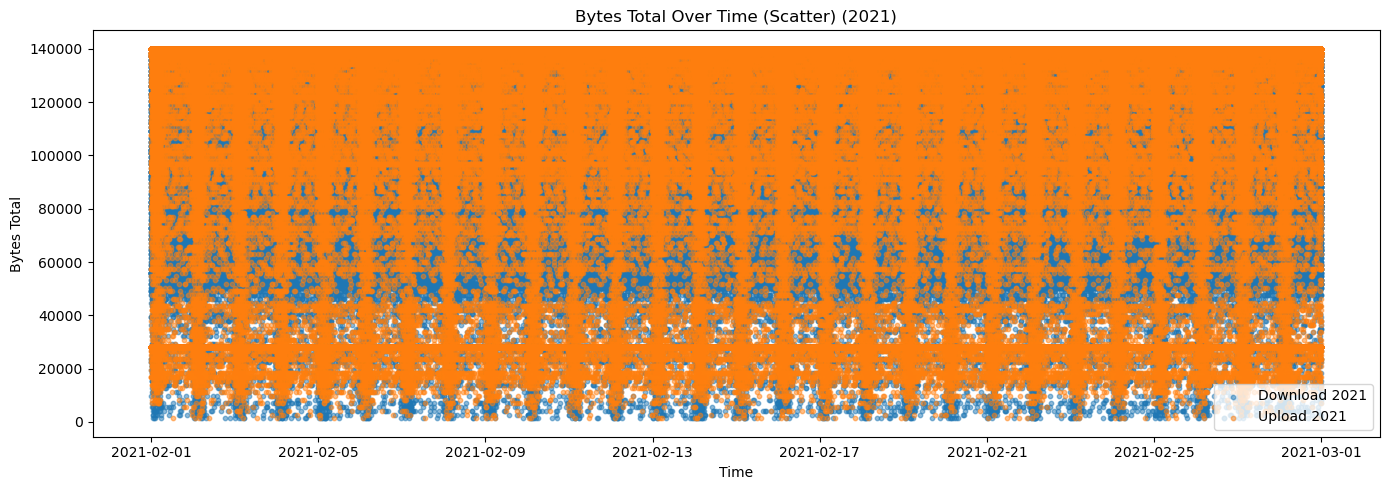

In [ ]:
# First peek at the data

def plot_bytes_total_scatter(dl, ul, year):
    plt.figure(figsize=(14, 5))
    plt.scatter(dl['dtime'].to_numpy(), dl['bytes_total'].to_numpy(), label=f'Download {year}', alpha=0.5, s=10)
    plt.scatter(ul['dtime'].to_numpy(), ul['bytes_total'].to_numpy(), label=f'Upload {year}', alpha=0.5, s=10)
    plt.xlabel('Time')
    plt.ylabel('Bytes Total')
    plt.title(f'Bytes Total Over Time (Scatter) ({year})')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_bytes_total_scatter(dl_21, ul_21, "2021")
# plot_bytes_total_scatter(dl_23, ul_23, "2023")

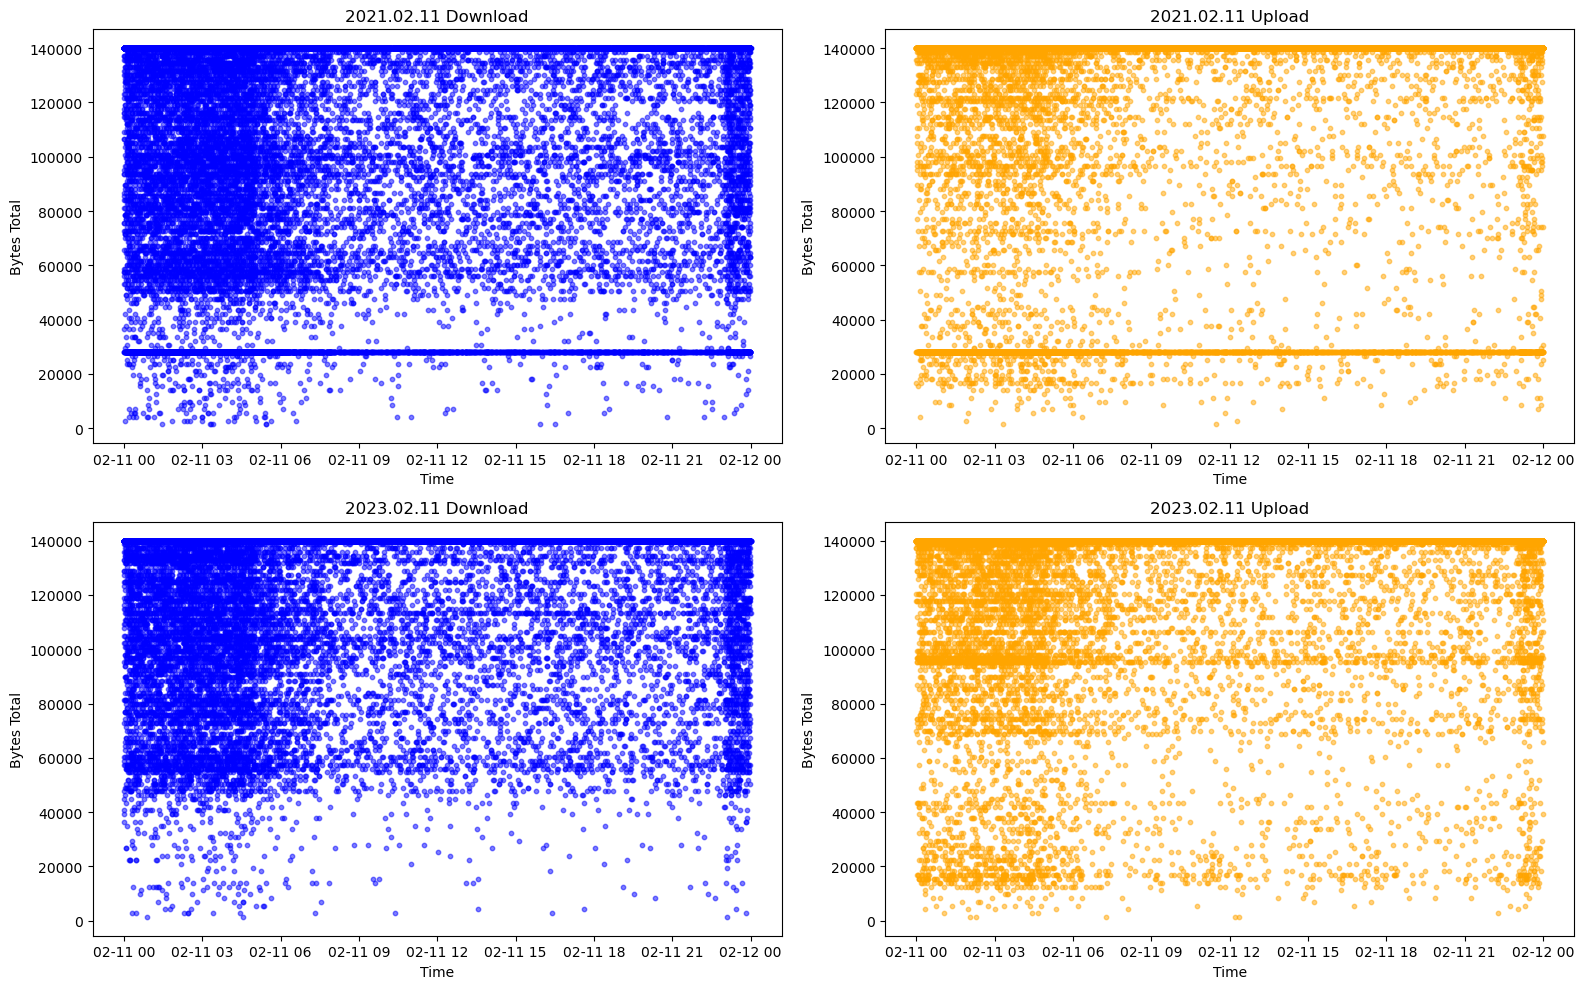

In [7]:
def plot_bytes_total_scatter(dataframes, day, titles, colors):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    for i, (df, title, color) in enumerate(zip(dataframes, titles, colors)):
        row, col = divmod(i, 2)
        df_filtered = df.filter(df['dtime'].dt.day() == day)
        
        axes[row, col].scatter(df_filtered['dtime'].to_numpy(), 
                              df_filtered['bytes_total'].to_numpy(), 
                              alpha=0.5, s=10, color=color)
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Bytes Total')
        axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()


dataframes = [dl_21, ul_21, dl_23, ul_23]
titles = ["2021.02.11 Download", "2021.02.11 Upload", 
          "2023.02.11 Download", "2023.02.11 Upload"]
colors = ["blue", "orange", "blue", "orange"]

plot_bytes_total_scatter(dataframes, 11, titles, colors)


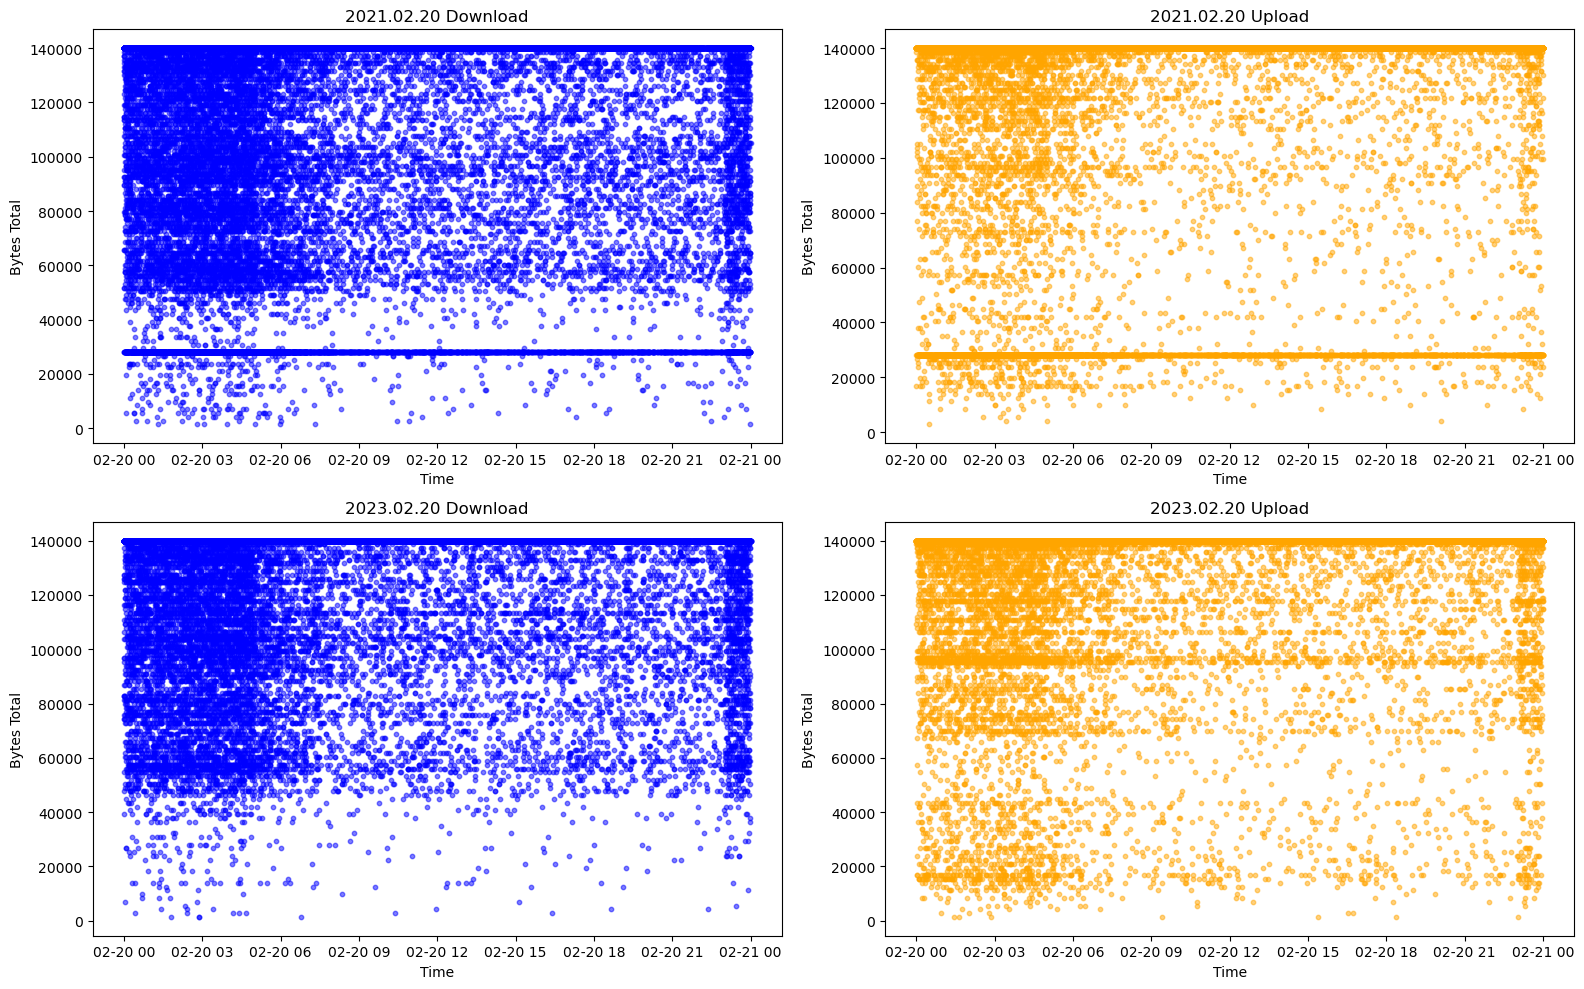

In [ ]:
# Pattern is consistent

dataframes = [dl_21, ul_21, dl_23, ul_23]
titles = ["2021.02.20 Download", "2021.02.20 Upload", 
          "2023.02.20 Download", "2023.02.20 Upload"]
colors = ["blue", "orange", "blue", "orange"]

plot_bytes_total_scatter(dataframes, 20, titles, colors)

In [9]:
# Strip on the top is caused by maxium bytes measure cutoff
# Strip visible on measurements from 2021 are probably caused by measuring process

print("Download 2021: min =", dl_21['bytes_total'].min(), ", max =", dl_21['bytes_total'].max())
print("Upload 2021: min =", ul_21['bytes_total'].min(), ", max =", ul_21['bytes_total'].max())
print("Download 2023: min =", dl_23['bytes_total'].min(), ", max =", dl_23['bytes_total'].max())
print("Upload 2023: min =", ul_23['bytes_total'].min(), ", max =", ul_23['bytes_total'].max())

Download 2021: min = 1400 , max = 140000
Upload 2021: min = 1400 , max = 140000
Download 2023: min = 1400 , max = 140000
Upload 2023: min = 1400 , max = 140000


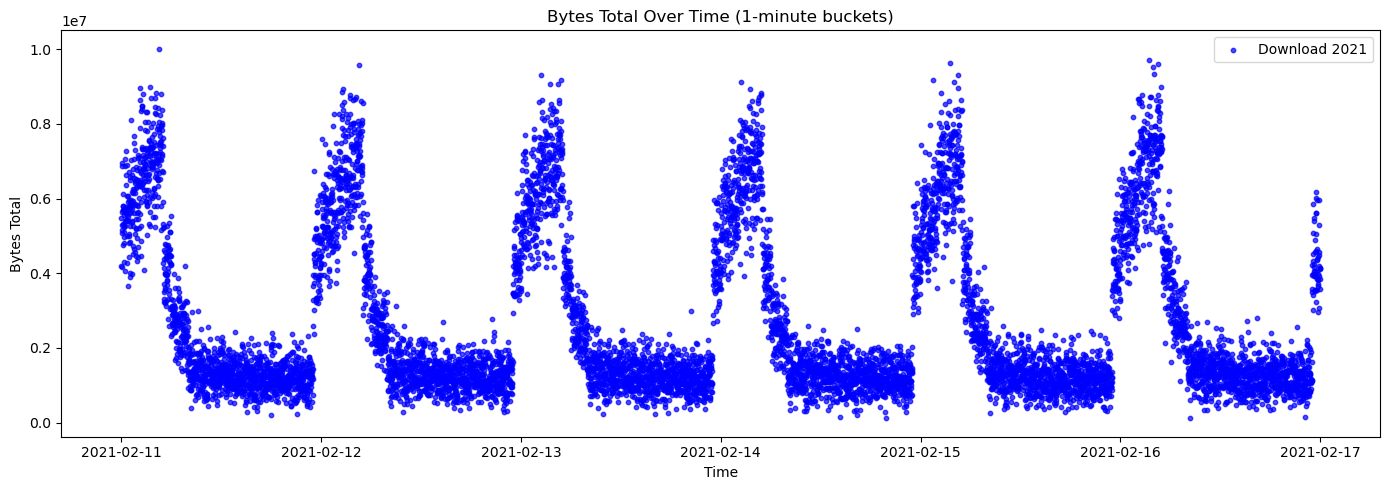

In [65]:
from scipy.interpolate import UnivariateSpline

# Create 1-minute buckets for bytes_total and save x (bucket start time) and y (sum of bytes_total per bucket)

def create_buckets(df, day, bucket_size: str, interval = 5):
    df_filtered = df.filter((df['dtime'].dt.day() >= day) & (df['dtime'].dt.day() < day + interval))

    buckets = (
        df_filtered
        .with_columns(
            pl.col("dtime").dt.truncate(bucket_size).alias("time_bucket")
        )
        .group_by("time_bucket")
        .agg(pl.col("bytes_total").sum().alias("bytes_total_sum"))
        .sort("time_bucket")
    )
    
    x_time = buckets["time_bucket"].to_numpy()
    y = buckets["bytes_total_sum"].to_numpy()
    x_numeric = (x_time - x_time[0]) / np.timedelta64(1, 'm')
    return x_numeric, y, x_time


x_numeric, y, x_time = create_buckets(dl_21, 11, "1m", interval = 6)
plt.figure(figsize=(14, 5))
# plt.plot(x_time, y_fit, label="Fitted Curve", color="red", linewidth=2)
plt.scatter(x_time, y, label="Download 2021", color="blue", s=10, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Bytes Total')
plt.title('Bytes Total Over Time (1-minute buckets)')
plt.legend()
plt.tight_layout()
plt.show()

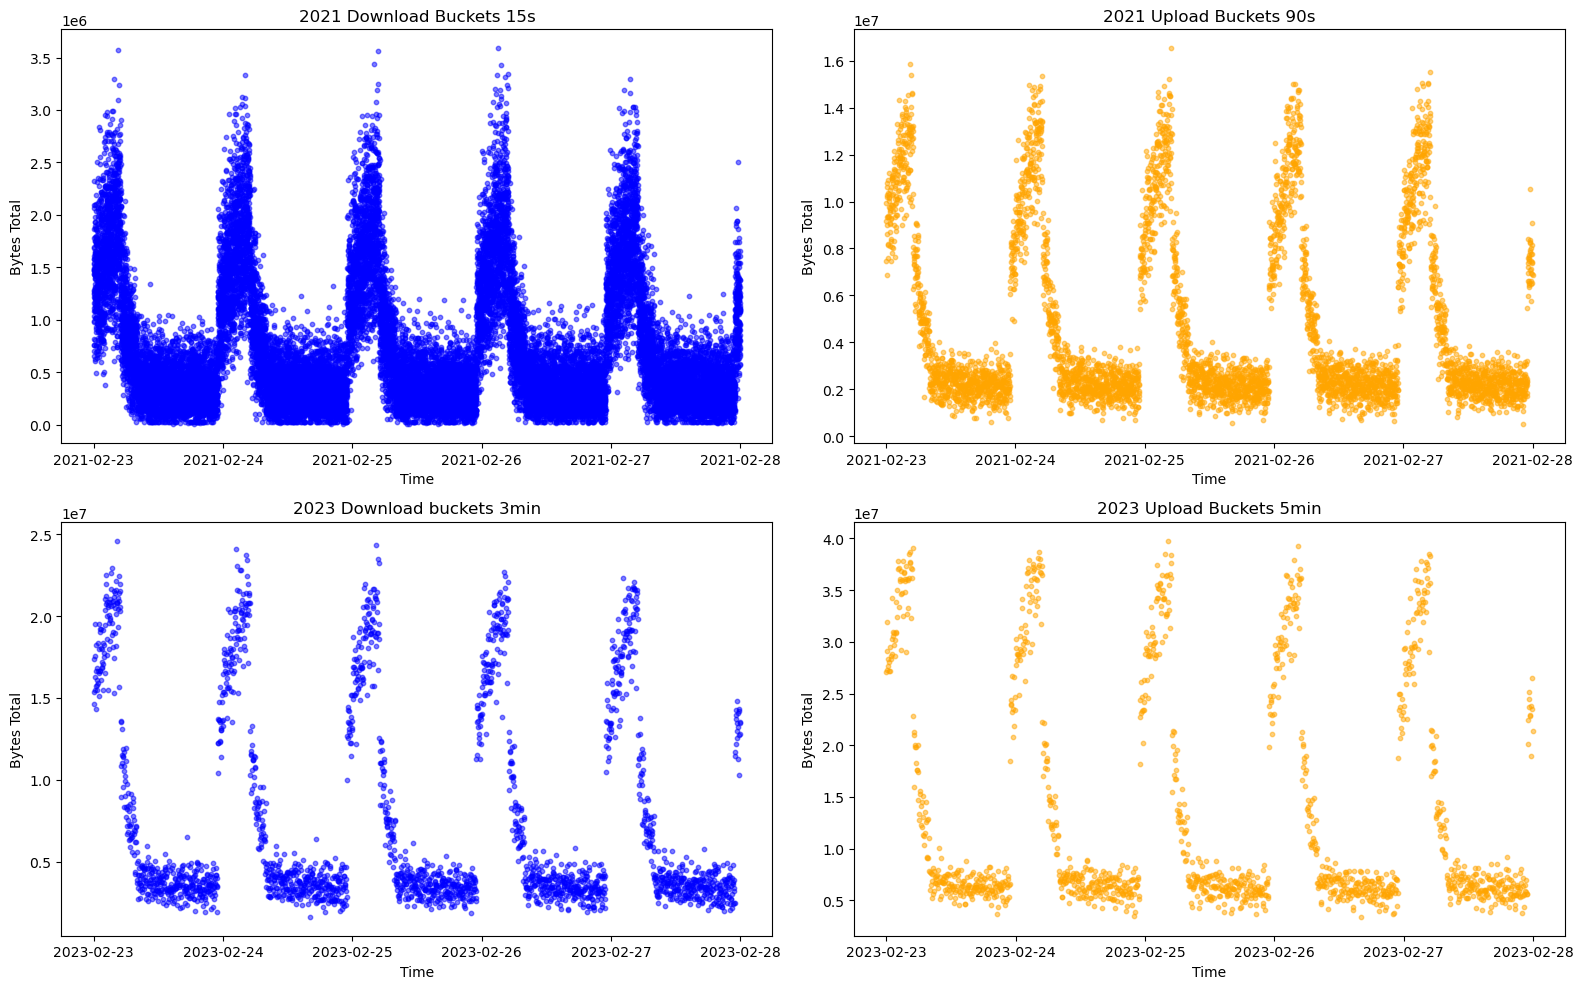

In [57]:
def plot_four_subplots_buckets(dataframes, day, titles, colors, bucket_size):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    for i, (df, title, color, bucket_size) in enumerate(zip(dataframes, titles, colors, bucket_sizes)):
        row, col = divmod(i, 2)
        # Apply create_buckets to the dataframe for the given day
        x_numeric, y, bucket_times = create_buckets(df, day, bucket_size)
        axes[row, col].scatter(bucket_times, y, alpha=0.5, s=10, color=color)
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Bytes Total')
        axes[row, col].set_title(title)
    plt.tight_layout()
    plt.show()

# Example usage with our four dataframes for day 11:
dataframes = [dl_21, ul_21, dl_23, ul_23]
titles = ["2021 Download Buckets 15s", "2021 Upload Buckets 90s",
          "2023 Download buckets 3min", "2023 Upload Buckets 5min"]
colors = ["blue", "orange", "blue", "orange"]
bucket_sizes = ["15s", "90s", "3m", "5m"]

plot_four_subplots_buckets(dataframes, 23, titles, colors, bucket_sizes)

**Important note:**
During the day there is higher density of operations, but with smaller total bytes.

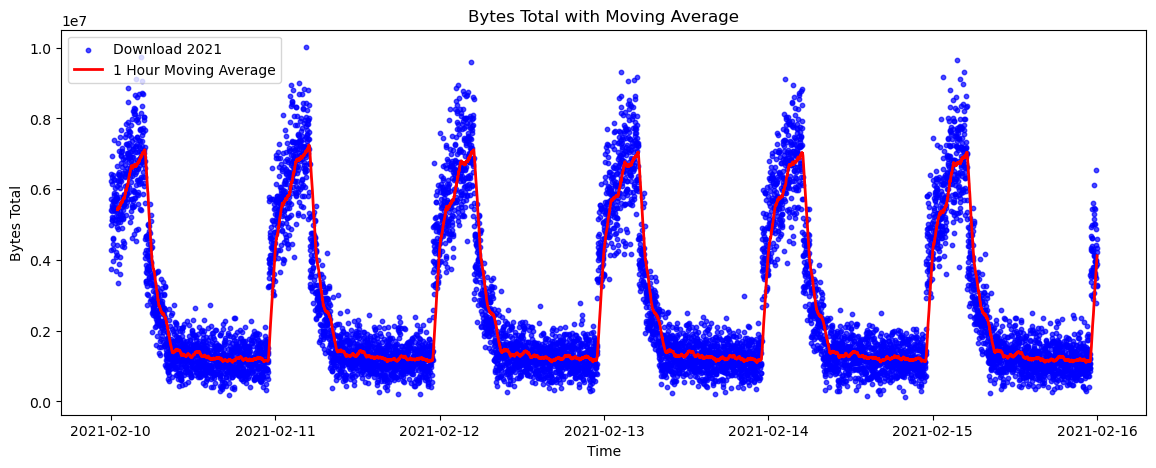

In [88]:
def fit_moving_average_trend(x_numeric, y, x_time, window=60):
    # Calculate moving average
    y_smooth = np.convolve(y, np.ones(window)/window, mode='valid')
    x_smooth = x_numeric[window-1:]
    
    # Convert back to time
    x_time_smooth = x_time[window-1:]
    
    return x_time_smooth, y_smooth

x_numeric, y, x_time = create_buckets(dl_21, 10, "1m", interval = 6)
x_time_smooth, y_smooth = fit_moving_average_trend(x_numeric, y, x_time, window=60)

plt.figure(figsize=(14, 5))
plt.scatter(x_time, y, label="Download 2021", color="blue", s=10, alpha=0.7)
plt.plot(x_time_smooth, y_smooth, label="1 Hour Moving Average", color="red", linewidth=2)
plt.xlabel('Time')
plt.ylabel('Bytes Total')
plt.title('Bytes Total with Moving Average')
plt.legend()
plt.show()

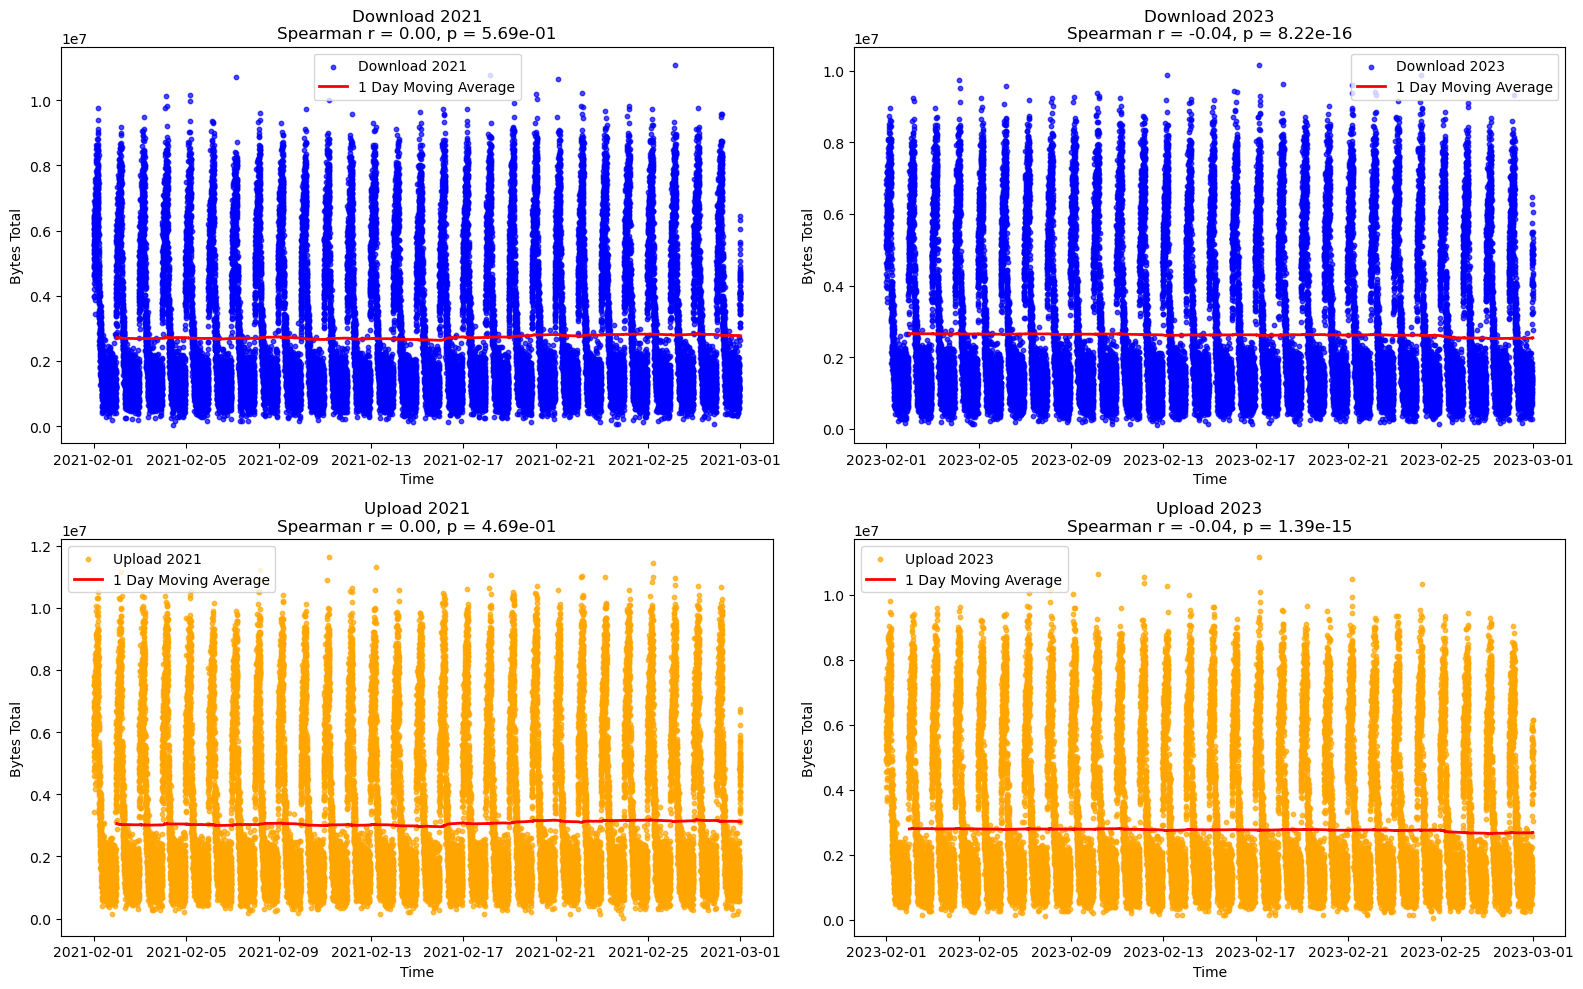

In [94]:
from scipy.stats import spearmanr

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

dataframes = [dl_21, dl_23, ul_21, ul_23]
titles = ["Download 2021", "Download 2023", "Upload 2021", "Upload 2023"]
colors = ["blue", "blue", "orange", "orange"]

for ax, df, title, color in zip(axes.flat, dataframes, titles, colors):
    x_numeric, y, x_time = create_buckets(df, 1, "1m", interval=28)
    x_time_smooth, y_smooth = fit_moving_average_trend(x_numeric, y, x_time, window=24*60)
    

    corr_coef, p_value = spearmanr(x_numeric, y)
    
    ax.scatter(x_time, y, s=10, alpha=0.7, color=color, label=title)
    ax.plot(x_time_smooth, y_smooth, color="red", linewidth=2, label="1 Day Moving Average")
    ax.set_xlabel("Time")
    ax.set_ylabel("Bytes Total")
    ax.set_title(f"{title}\nSpearman r = {corr_coef:.2f}, p = {p_value:.2e}")
    ax.legend()

plt.tight_layout()

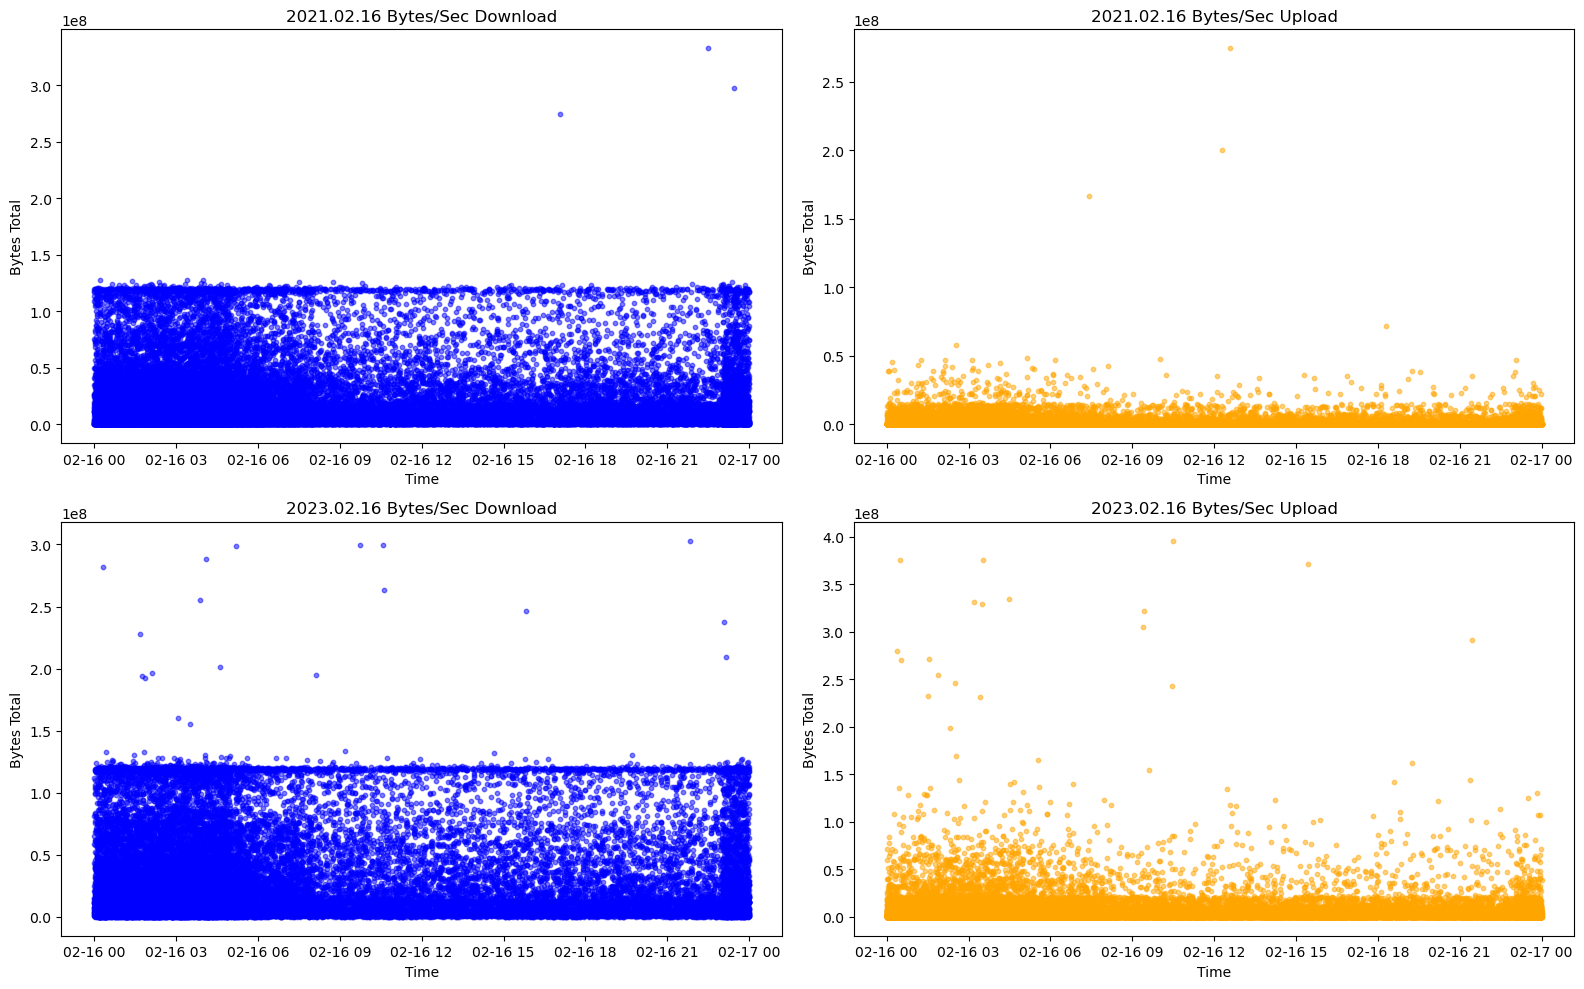

In [107]:
def plot_bytes_total_scatter(dataframes, day, titles, colors):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    for i, (df, title, color) in enumerate(zip(dataframes, titles, colors)):
        row, col = divmod(i, 2)
        df_filtered = df.filter(df['dtime'].dt.day() == day)
        
        axes[row, col].scatter(df_filtered['dtime'].to_numpy(), 
                              df_filtered['bytes_sec'].to_numpy(), 
                              alpha=0.5, s=10, color=color)
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Bytes Total')
        axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()


dataframes = [dl_21, ul_21, dl_23, ul_23]
titles = ["2021.02.16 Bytes/Sec Download", "2021.02.16 Bytes/Sec Upload", 
          "2023.02.16 Bytes/Sec Download", "2023.02.16 Bytes/Sec Upload"]
colors = ["blue", "orange", "blue", "orange"]

plot_bytes_total_scatter(dataframes, 16, titles, colors)

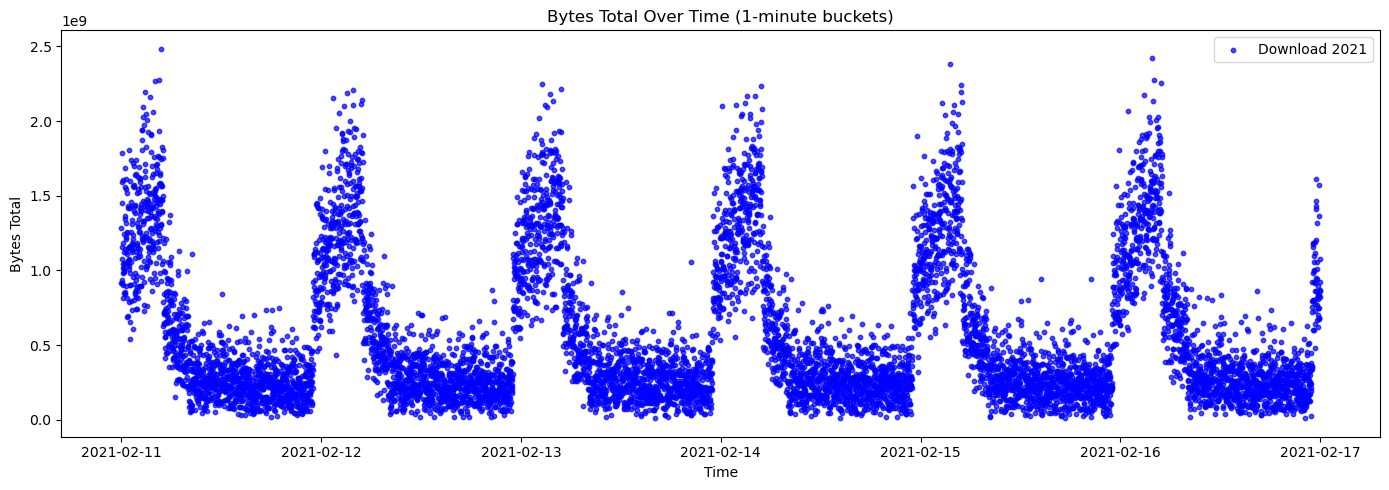

In [106]:
def create_buckets_2(df, day, bucket_size: str, interval = 5):
    df_filtered = df.filter((df['dtime'].dt.day() >= day) & (df['dtime'].dt.day() < day + interval))

    buckets = (
        df_filtered
        .with_columns(
            pl.col("dtime").dt.truncate(bucket_size).alias("time_bucket")
        )
        .group_by("time_bucket")
        .agg(pl.col("bytes_sec").sum().alias("bytes_sec_sum"))
        .sort("time_bucket")
    )
    
    x_time = buckets["time_bucket"].to_numpy()
    y = buckets["bytes_sec_sum"].to_numpy()
    x_numeric = (x_time - x_time[0]) / np.timedelta64(1, 'm')
    return x_numeric, y, x_time


x_numeric, y, x_time = create_buckets_2(dl_21, 11, "1m", interval = 6)
plt.figure(figsize=(14, 5))
# plt.plot(x_time, y_fit, label="Fitted Curve", color="red", linewidth=2)
plt.scatter(x_time, y, label="Download 2021", color="blue", s=10, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Bytes Total')
plt.title('Bytes Total Over Time (1-minute buckets)')
plt.legend()
plt.tight_layout()
plt.show()

Length of dl_21 dataframe: 1000104
Length of ping_dl_21 dataframe: 2530196


C:\Users\Jakub\AppData\Local\Temp\ipykernel_14176\1300726616.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\Jakub\miniconda3\envs\crisp-dm-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


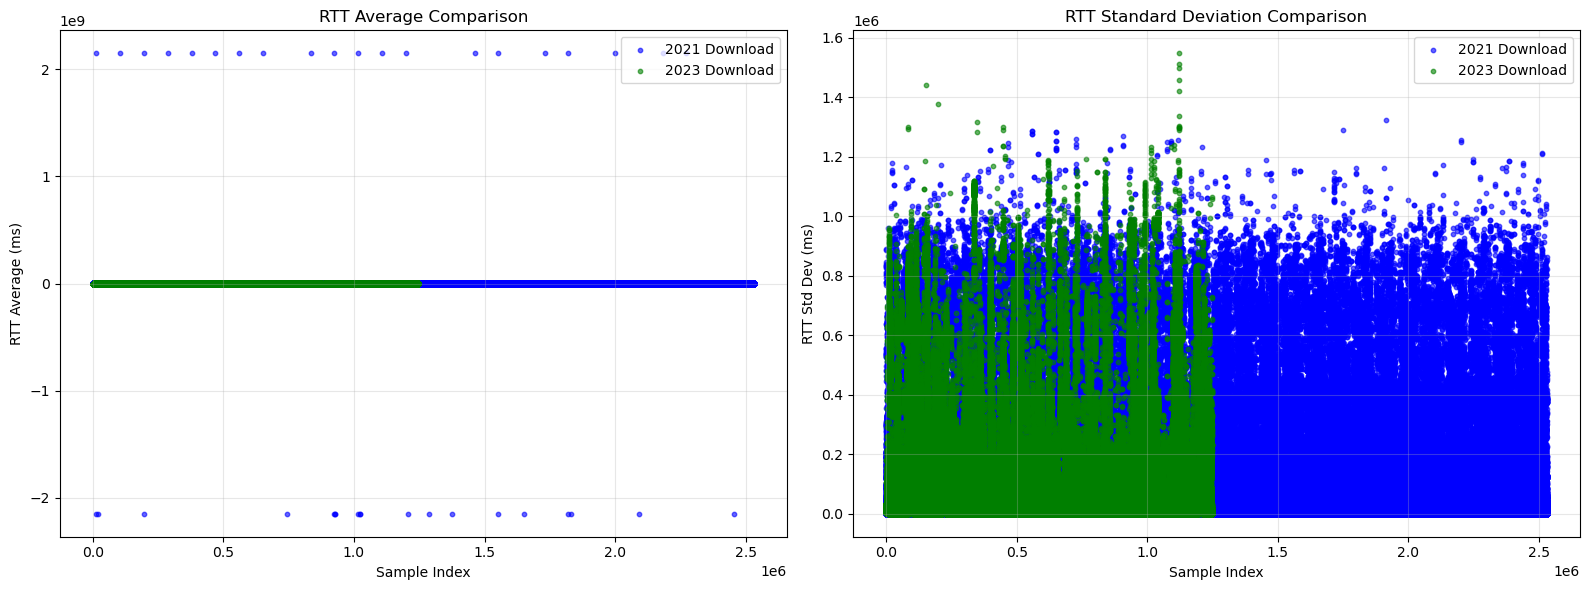


=== Success/Failure Statistics ===
2021 Download - Successes: 330380360, Failures: 15274793
2023 Download - Successes: 186764393, Failures: 7461763


In [109]:
# Print dataframe lengths
print(f"Length of dl_21 dataframe: {len(dl_21)}")
print(f"Length of ping_dl_21 dataframe: {len(ping_dl_21)}")

# Create combined plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RTT Average comparison
ax1.scatter(range(len(ping_dl_21)), ping_dl_21['rtt_avg'].to_numpy(), 
           alpha=0.6, s=10, color='blue', label='2021 Download')
ax1.scatter(range(len(ping_dl_23)), ping_dl_23['rtt_avg'].to_numpy(), 
           alpha=0.6, s=10, color='green', label='2023 Download')
ax1.set_title('RTT Average Comparison')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('RTT Average (ms)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# RTT Standard Deviation comparison
ax2.scatter(range(len(ping_dl_21)), ping_dl_21['rtt_std'].to_numpy(), 
           alpha=0.6, s=10, color='blue', label='2021 Download')
ax2.scatter(range(len(ping_dl_23)), ping_dl_23['rtt_std'].to_numpy(), 
           alpha=0.6, s=10, color='green', label='2023 Download')
ax2.set_title('RTT Standard Deviation Comparison')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('RTT Std Dev (ms)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print additional info about success/failure rates
print(f"\n=== Success/Failure Statistics ===")
print(f"2021 Download - Successes: {ping_dl_21['successes'].sum()}, Failures: {ping_dl_21['failures'].sum()}")
print(f"2023 Download - Successes: {ping_dl_23['successes'].sum()}, Failures: {ping_dl_23['failures'].sum()}")

## Modeling